# GIGANTES TECNOLÓGICOS

## Importación de los datos

In [1]:
# Import libreries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from functions import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
company_data = download_stock_data("AAPL")
companies = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Alphabet': 'GOOGL',
    'NVIDIA': 'NVDA'
}

## Limpieza de datos

In [4]:
# Normalizar los nombres de las columnas
company_data = normalizar_nombres_columnas(company_data)

In [5]:
data_report = data_quality_report(company_data)

----- Informe de Calidad de Datos -----

Valores nulos por columna:
 open            0
high            0
low             0
close           0
volume          0
dividends       0
stock_splits    0
dtype: int64

Número de filas duplicadas: 0

Tipos de datos:
 open            float64
high            float64
low             float64
close           float64
volume            int64
dividends       float64
stock_splits    float64
dtype: object

Descripción estadística de las columnas numéricas:
               open         high          low        close        volume  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean     90.224649    91.189309    89.316170    90.297348  1.198232e+08   
std      63.280303    63.941939    62.655693    63.334366  6.878668e+07   
min      20.642058    21.025082    20.520499    20.720037  1.578593e+07   
25%      33.500441    33.637798    33.330515    33.472515  7.360430e+07   
50%      57.458703    58.298134    56.820057    57.190182 

### Ingeniería de caracteristicas

Agregar retornos logarítmicos (Log Returns):

Los retornos logarítmicos pueden ser útiles para predecir el comportamiento del precio a futuro, ya que tienden a estabilizar la varianza a lo largo del tiempo.

In [6]:
company_data['log_return'] = np.log(company_data['close'] / company_data['close'].shift(1))
company_data.dropna(inplace=True)  # Eliminar filas con NaN generados por shift

Volatilidad histórica:

La volatilidad es un indicador clave en los mercados financieros y podría ayudarte a capturar la fluctuación de precios a lo largo del tiempo.

In [7]:
company_data['volatility'] = company_data['log_return'].rolling(window=30).std() * np.sqrt(30)
company_data.dropna(inplace=True)  # Eliminar filas con NaN

Media móvil (Moving Average):

Incluir medias móviles de 50 días, 100 días o más largas puede ayudarte a capturar tendencias más generales.

In [8]:
company_data['ma50'] = company_data['close'].rolling(window=50).mean()
company_data['ma100'] = company_data['close'].rolling(window=100).mean()
company_data.dropna(inplace=True)  # Eliminar filas con NaN

Relación entre volumen y precio (Volume-to-Price Ratio):

La relación entre el volumen y el precio puede ser un buen indicador de movimientos significativos en el mercado.

In [9]:
company_data['volume_to_price'] = company_data['volume'] / company_data['close']

Cálculo de retornos

In [10]:
company_data['daily_return'] = company_data['close'].pct_change()

Eliminar nulos posibles generados con la creación de columnas

In [11]:
company_data.dropna(inplace=True)

## Análisis exploratorio de datos (EDA)

In [12]:
company_data.dtypes

open               float64
high               float64
low                float64
close              float64
volume               int64
dividends          float64
stock_splits       float64
log_return         float64
volatility         float64
ma50               float64
ma100              float64
volume_to_price    float64
daily_return       float64
dtype: object

In [13]:
# 1. Descripción general de los datos
describe_data(company_data)

Descripción general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2387 entries, 2015-04-30 00:00:00-04:00 to 2024-10-22 00:00:00-04:00
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             2387 non-null   float64
 1   high             2387 non-null   float64
 2   low              2387 non-null   float64
 3   close            2387 non-null   float64
 4   volume           2387 non-null   int64  
 5   dividends        2387 non-null   float64
 6   stock_splits     2387 non-null   float64
 7   log_return       2387 non-null   float64
 8   volatility       2387 non-null   float64
 9   ma50             2387 non-null   float64
 10  ma100            2387 non-null   float64
 11  volume_to_price  2387 non-null   float64
 12  daily_return     2387 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 261.1 KB
None

Primeras 5 filas:
                                open       

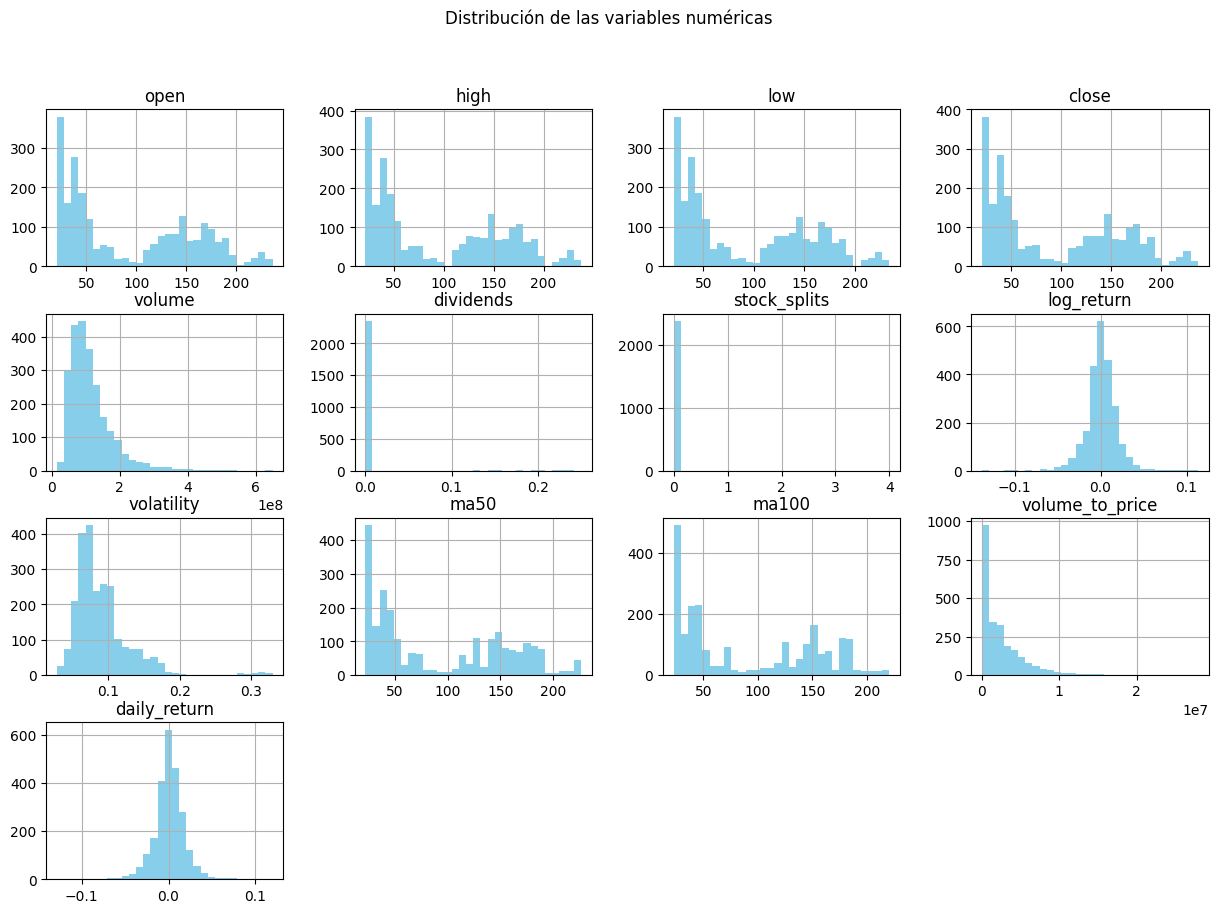

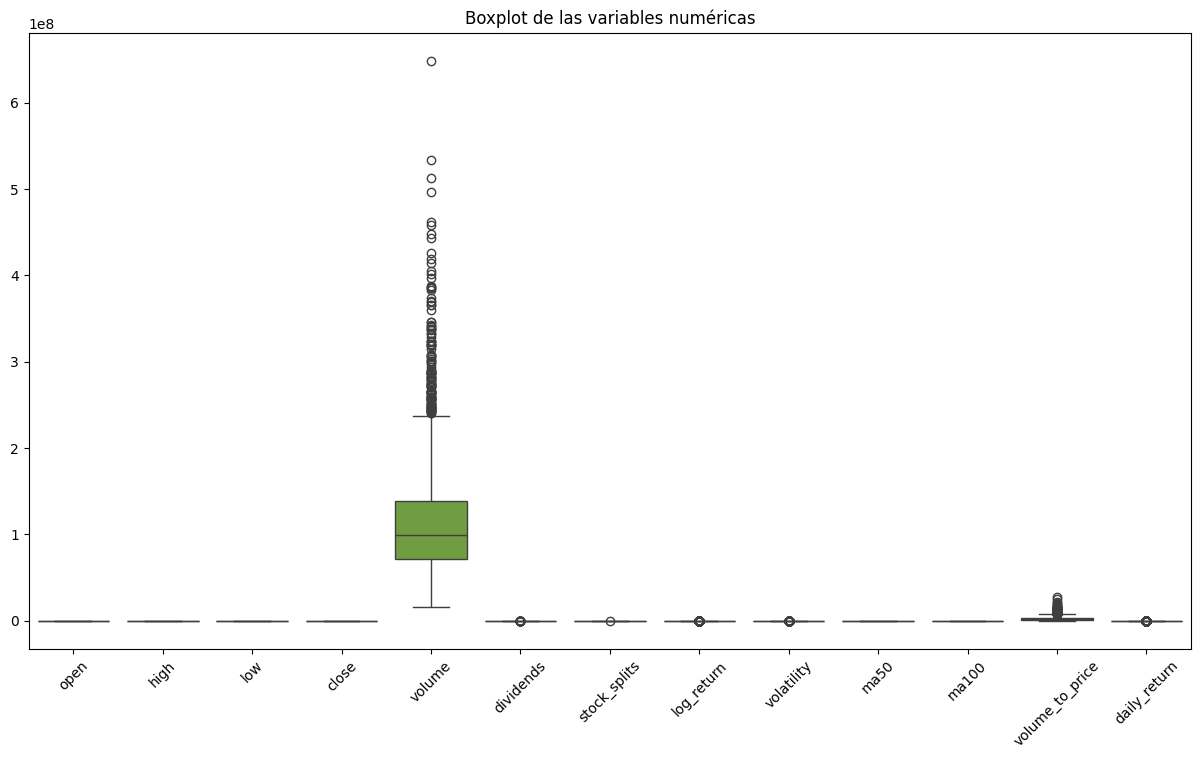

In [14]:
# 2. Visualizar las distribuciones y detectar outliers
plot_distributions(company_data)

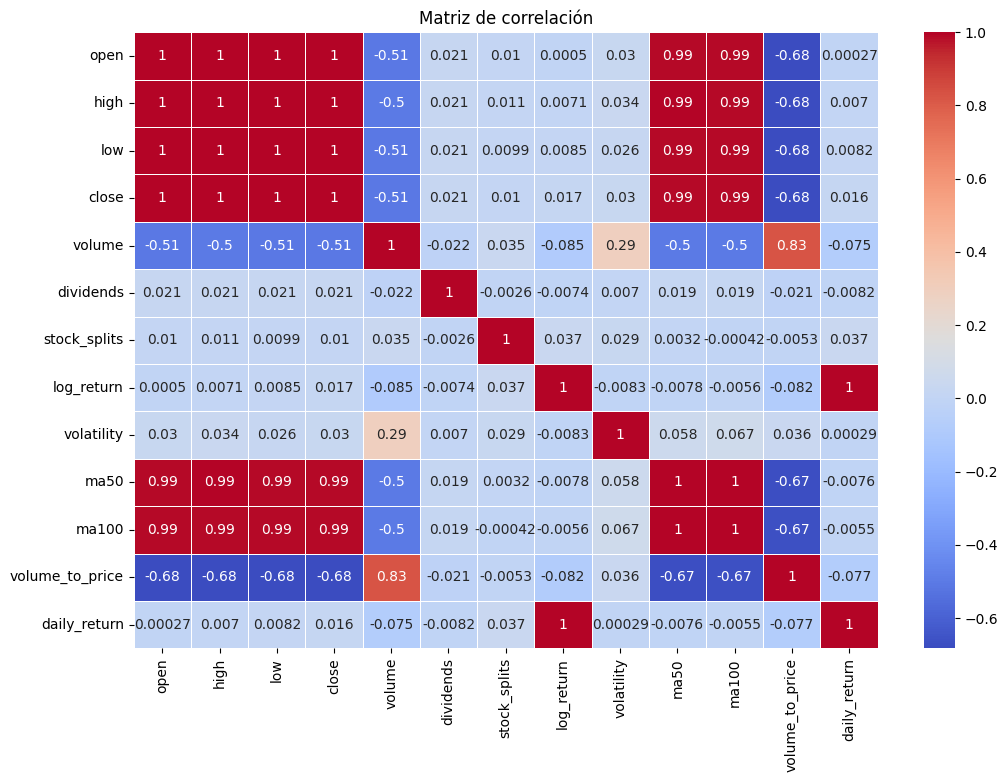

In [15]:
# 3. Matriz de correlación
plot_correlation_matrix(company_data)

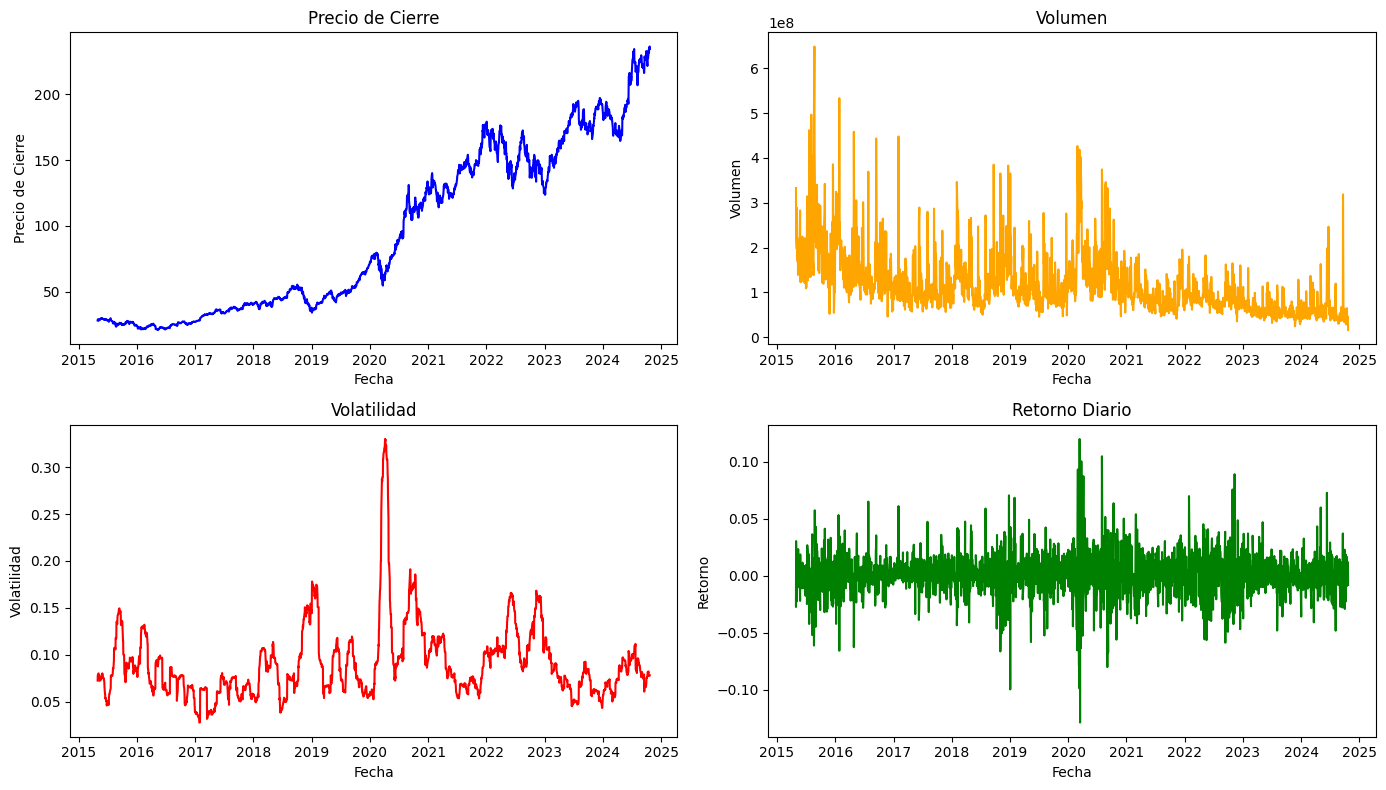

In [16]:
# 4. Visualización de series temporales
plot_time_series(company_data)

In [17]:
# 5. Detección de outliers
detect_outliers(company_data)

Número de outliers por variable:
open                 0
high                 0
low                  0
close                0
volume             120
dividends           38
stock_splits         1
log_return         132
volatility         104
ma50                 0
ma100                0
volume_to_price    116
daily_return       132
dtype: int64


## Modelos comparativa

Preprocesamiento de Datos

In [18]:
# Verificar datos faltantes
print(company_data.isnull().sum())

# Opciones de manejo de datos faltantes
#company_data.fillna(method='ffill', inplace=True)  # Forward Fill para series temporales


open               0
high               0
low                0
close              0
volume             0
dividends          0
stock_splits       0
log_return         0
volatility         0
ma50               0
ma100              0
volume_to_price    0
daily_return       0
dtype: int64


 Normalización o Escalado:

In [19]:
# Escalar las variables numéricas
scaler = StandardScaler()
scaled_data = scaler.fit_transform(company_data[['open', 'high', 'low', 'close', 'volume', 'volatility', 'log_return']])
scaled_df = pd.DataFrame(scaled_data, columns=['open', 'high', 'low', 'close', 'volume', 'volatility', 'log_return'])

Análisis de la distribución (Normalidad):

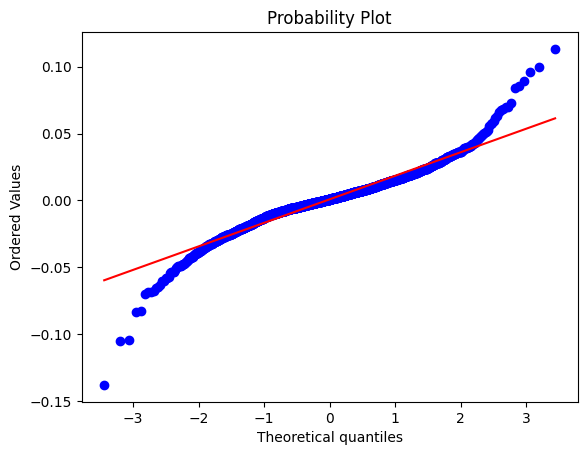

In [20]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Verificación de normalidad
stats.probplot(company_data['log_return'], dist="norm", plot=plt)
plt.show()

# Si es necesario, se pueden aplicar transformaciones
company_data['log_return'] = np.log1p(company_data['log_return'])  # Log-transformación


### Comparativa de modelos

1 Modelos Supervisados

Vamos a aplicar varios modelos supervisados, como regresión lineal, regresión de máquinas de soporte vectorial (SVR) y árboles de decisión para predecir valores futuros. Al final, compararemos estos resultados con Prophet, que está optimizado para series temporales.



1.1 Regresión Lineal: Un modelo básico pero efectivo para ver la relación entre variables.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Dividir los datos en entrenamiento y prueba
X = company_data[['open', 'high', 'low', 'volume', 'volatility', 'ma50', 'ma100']]
y = company_data['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = lin_reg.predict(X_test)
mse_lin_reg = mean_squared_error(y_test, y_pred)
print(f"Regresión Lineal MSE: {mse_lin_reg}")


Regresión Lineal MSE: 0.4432063252970992


1.2 Máquinas de Soporte Vectorial (SVR): El modelo SVR es útil para capturar relaciones no lineales entre las variables.

In [22]:
from sklearn.svm import SVR

# Ajustar el modelo SVR
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_svr = svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"SVR MSE: {mse_svr}")


SVR MSE: 2489.759035755053


1.3 Árboles de Decisión: Los árboles de decisión pueden manejar relaciones complejas entre variables, pero son propensos a sobreajustarse.

In [23]:
from sklearn.tree import DecisionTreeRegressor

# Ajustar el modelo Árbol de Decisión
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_tree = tree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Árbol de Decisión MSE: {mse_tree}")


Árbol de Decisión MSE: 1.770815917232547


### Ajuste hiperparámetros

Realizamos el ajuste de hiperparámetros para optimizar los modelos supervisados. Aquí usamos GridSearchCV para ajustar los hiperparámetros de SVR y los árboles de decisión.

In [24]:
from sklearn.model_selection import GridSearchCV

# Ajuste de hiperparámetros para SVR
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
grid_search_svr = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, y_train)

# Resultados del mejor modelo
print("Mejores hiperparámetros para SVR:", grid_search_svr.best_params_)


Mejores hiperparámetros para SVR: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Evaluación del Modelo

Finalmente, comparamos los resultados de los modelos usando MSE (Mean Squared Error) o MAE (Mean Absolute Error), lo que permite evaluar cuál modelo se adapta mejor a los datos.

In [25]:
print(f"Comparación de Modelos:")
print(f"Regresión Lineal MSE: {mse_lin_reg}")
print(f"SVR MSE: {mse_svr}")
print(f"Árbol de Decisión MSE: {mse_tree}")


Comparación de Modelos:
Regresión Lineal MSE: 0.4432063252970992
SVR MSE: 2489.759035755053
Árbol de Decisión MSE: 1.770815917232547


2 Modelo de Series Temporales: Prophet

Finalmente, implementamos Prophet, que es ideal para la predicción de series temporales y captura tendencias y estacionalidades.

18:21:13 - cmdstanpy - INFO - Chain [1] start processing
18:21:14 - cmdstanpy - INFO - Chain [1] done processing


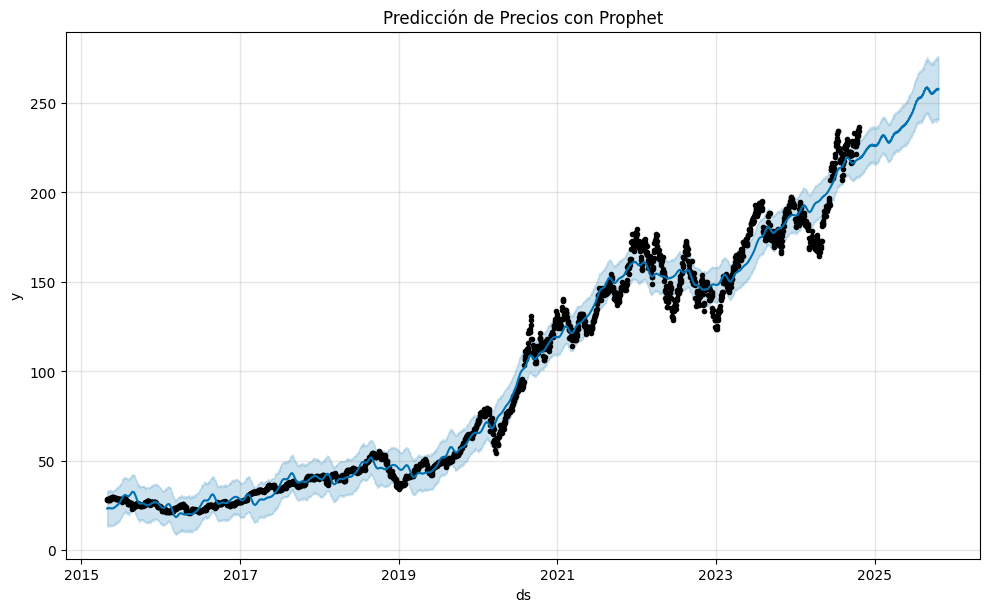

In [26]:
from prophet import Prophet

# Preparar los datos para Prophet
df_prophet = company_data[['close']].reset_index()
df_prophet.columns = ['ds', 'y']

# Eliminar la zona horaria de la columna 'ds'
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(df_prophet)

# Predecir valores futuros
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Mostrar los resultados
model.plot(forecast)
plt.title("Predicción de Precios con Prophet")
plt.show()


Prophet a detalle

18:21:16 - cmdstanpy - INFO - Chain [1] start processing
18:21:17 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

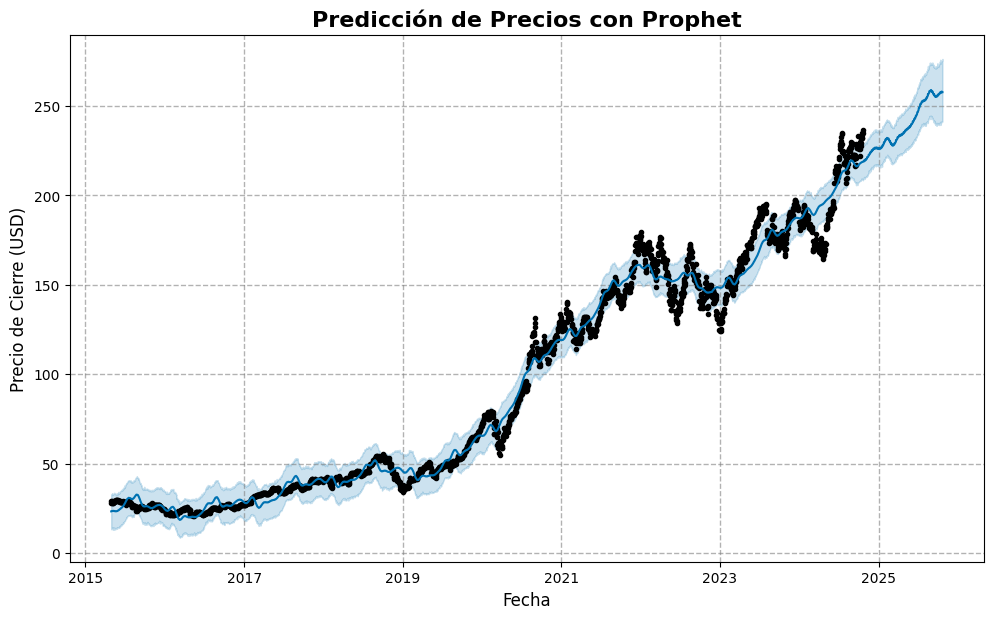

<Figure size 1000x600 with 0 Axes>

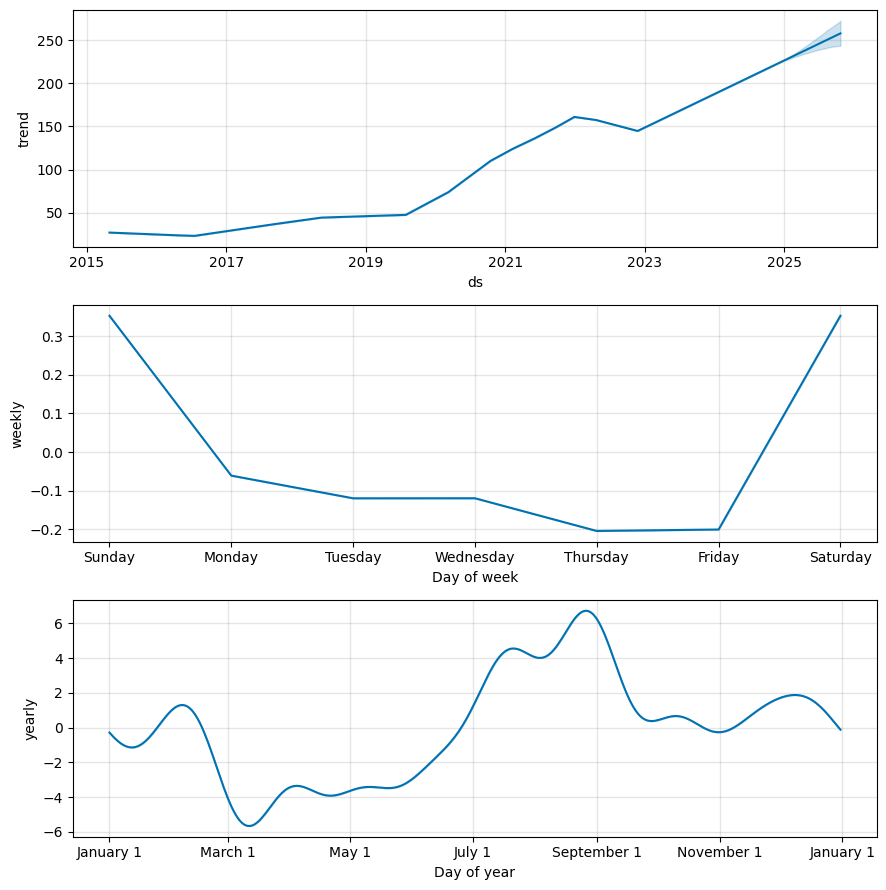

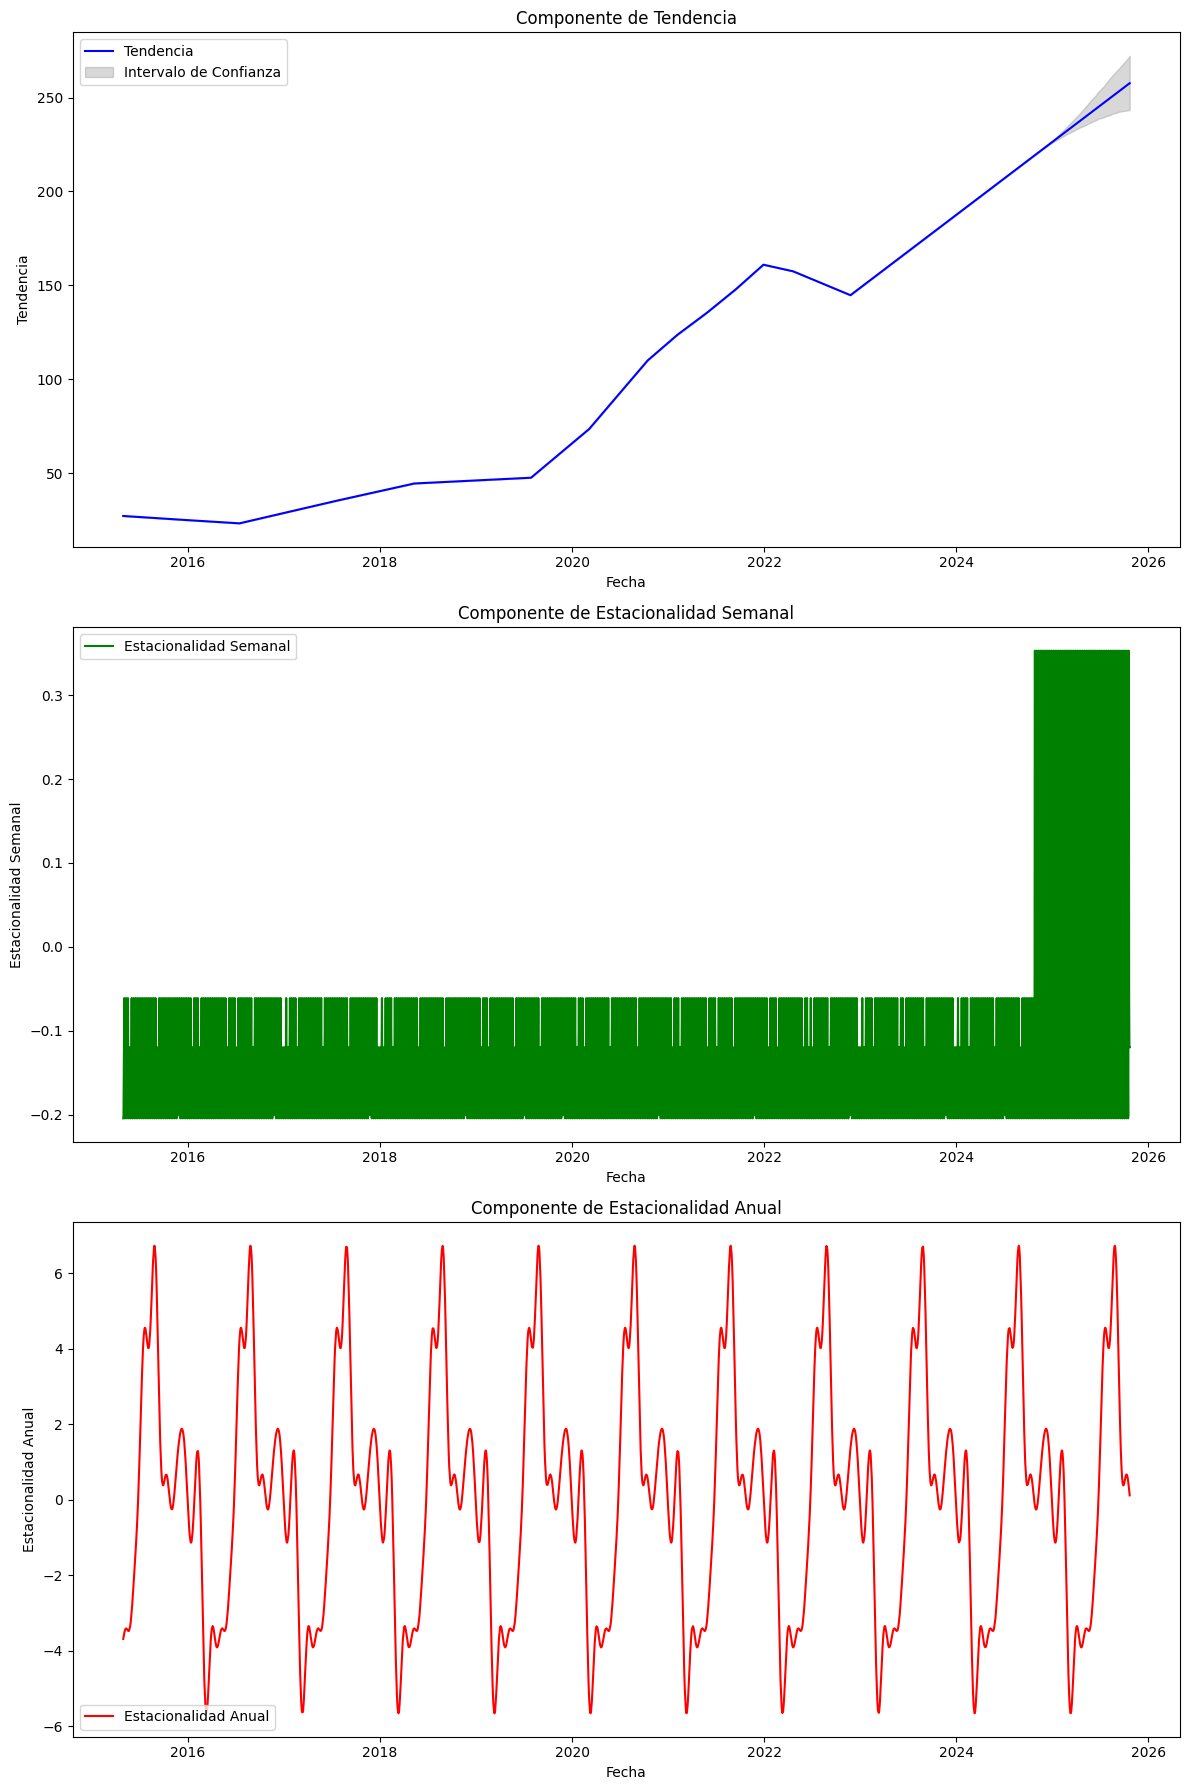

In [27]:
import matplotlib.pyplot as plt
from prophet import Prophet

# Preparar los datos para Prophet
df_prophet = company_data[['close']].reset_index()
df_prophet.columns = ['ds', 'y']

# Eliminar la zona horaria de la columna 'ds'
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(df_prophet)

# Predecir valores futuros
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Gráfico detallado con los resultados de Prophet
plt.figure(figsize=(10, 6))
model.plot(forecast)
plt.title("Predicción de Precios con Prophet", fontsize=16, weight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Graficar los componentes del modelo (tendencias y estacionalidad)
plt.figure(figsize=(10, 6))
model.plot_components(forecast)
plt.show()

# Gráfico personalizado de los componentes para mayor detalle
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Tendencia
ax[0].plot(forecast['ds'], forecast['trend'], color='blue', label='Tendencia')
ax[0].fill_between(forecast['ds'], forecast['trend_lower'], forecast['trend_upper'], color='gray', alpha=0.3, label='Intervalo de Confianza')
ax[0].set_title('Componente de Tendencia')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Tendencia')
ax[0].legend()

# Estacionalidad semanal
ax[1].plot(forecast['ds'], forecast['weekly'], color='green', label='Estacionalidad Semanal')
ax[1].set_title('Componente de Estacionalidad Semanal')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Estacionalidad Semanal')
ax[1].legend()

# Estacionalidad anual
ax[2].plot(forecast['ds'], forecast['yearly'], color='red', label='Estacionalidad Anual')
ax[2].set_title('Componente de Estacionalidad Anual')
ax[2].set_xlabel('Fecha')
ax[2].set_ylabel('Estacionalidad Anual')
ax[2].legend()

plt.tight_layout()
plt.show()


## Generación de datos y comparativa

Iterar sobre todas las compañías aplicando el EDA y limpieza

Columnas disponibles para Apple: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Descripción general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-10-22 00:00:00-04:00 to 2024-10-22 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Volume        2517 non-null   int64  
 5   Dividends     2517 non-null   float64
 6   Stock Splits  2517 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.3 KB
None

Descripción estadística de las variables numéricas:
              Open         High          Low        Close        Volume  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean     90.224649    91.189309    8

<Figure size 1400x800 with 0 Axes>

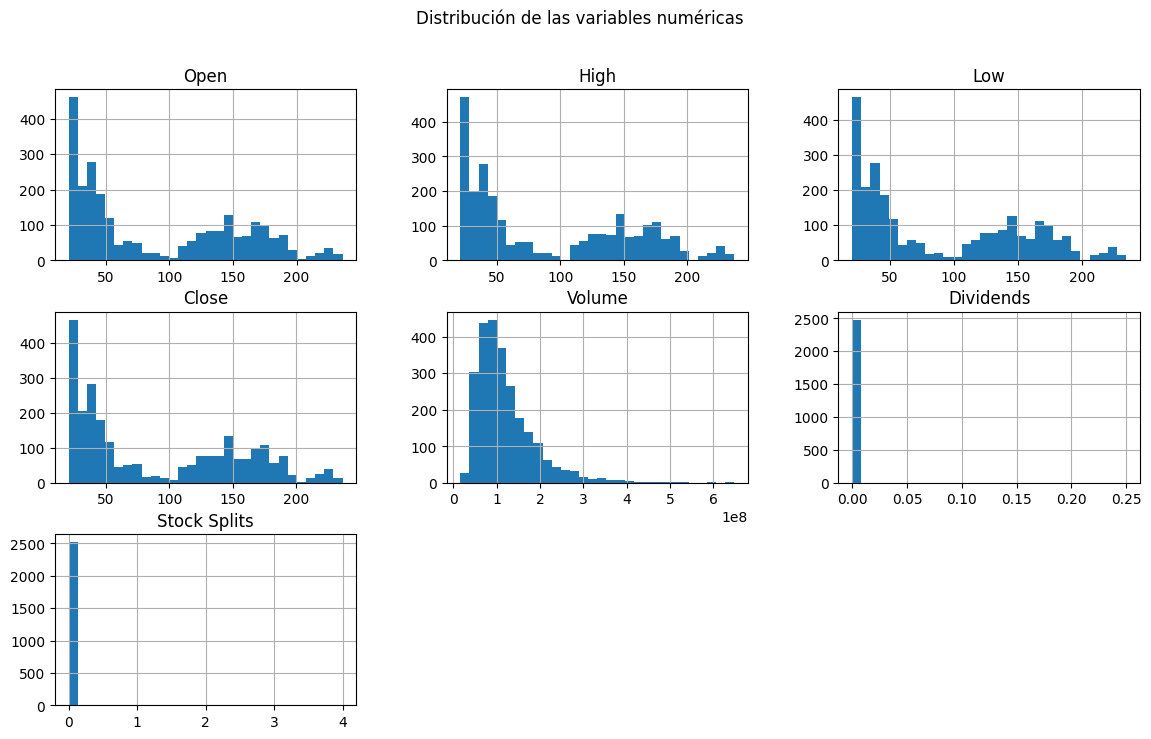

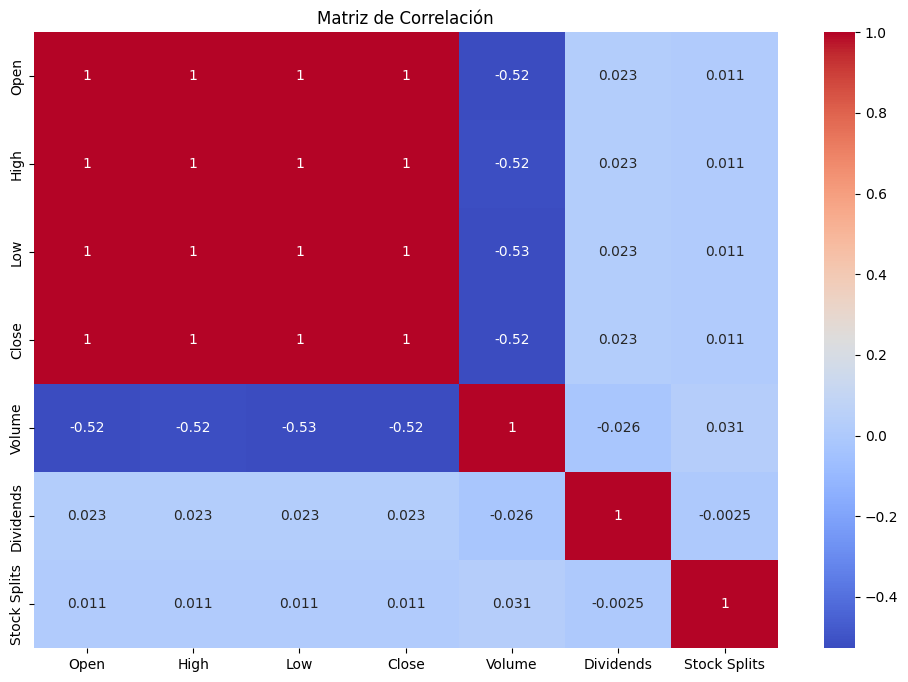

18:26:48 - cmdstanpy - INFO - Chain [1] start processing
18:26:48 - cmdstanpy - INFO - Chain [1] done processing


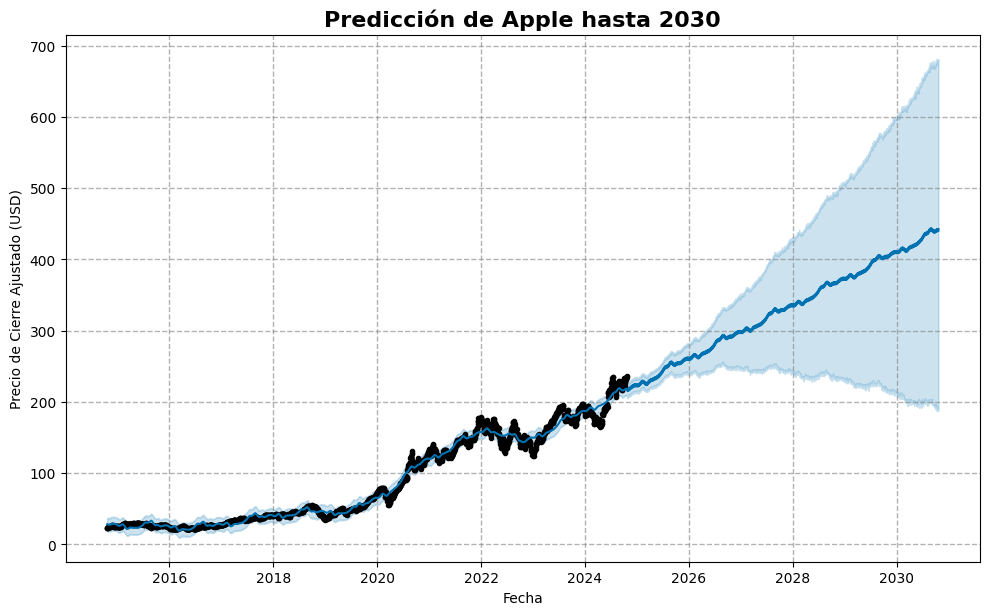

Columnas disponibles para Microsoft: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Descripción general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-10-22 00:00:00-04:00 to 2024-10-22 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Volume        2517 non-null   int64  
 5   Dividends     2517 non-null   float64
 6   Stock Splits  2517 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.3 KB
None

Descripción estadística de las variables numéricas:
              Open         High          Low        Close        Volume  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean    174.873526   176.536237 

<Figure size 1400x800 with 0 Axes>

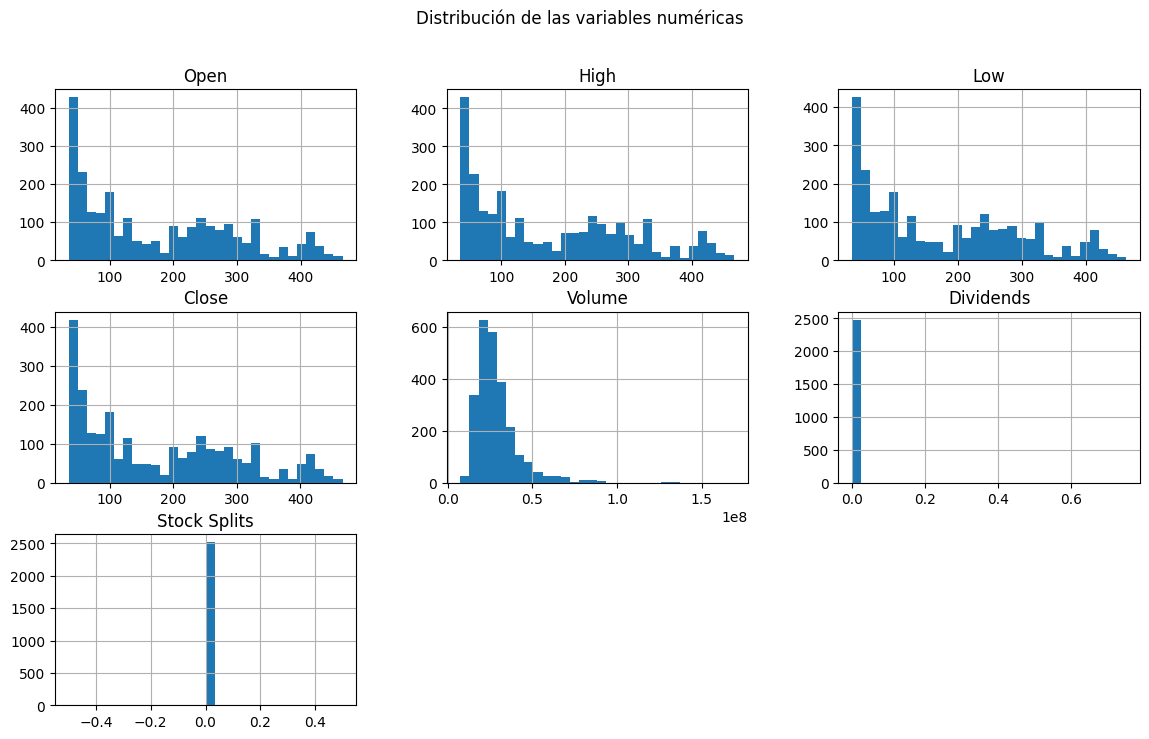

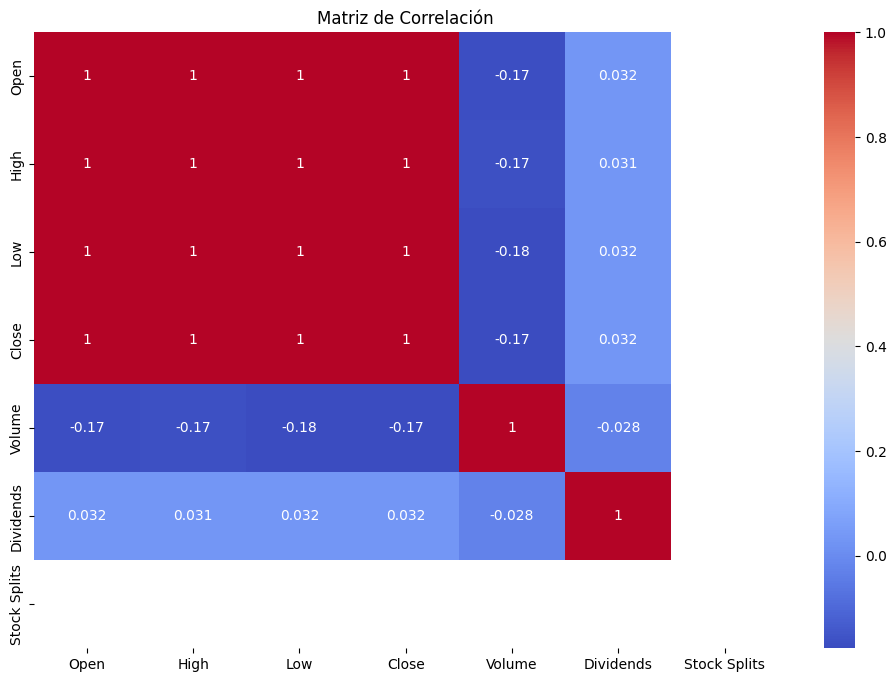

18:26:53 - cmdstanpy - INFO - Chain [1] start processing
18:26:55 - cmdstanpy - INFO - Chain [1] done processing


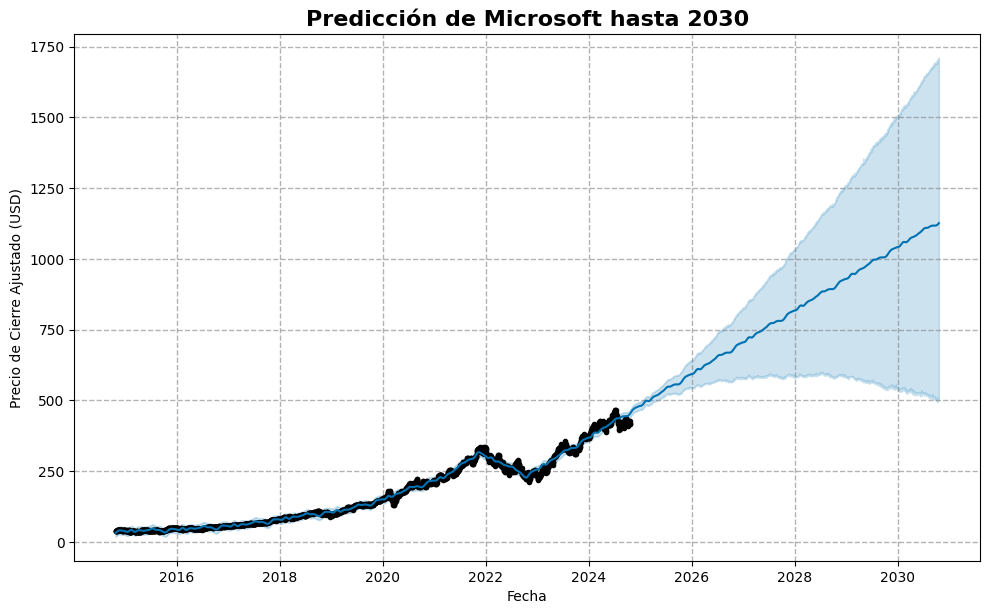

Columnas disponibles para Amazon: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Descripción general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-10-22 00:00:00-04:00 to 2024-10-22 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Volume        2517 non-null   int64  
 5   Dividends     2517 non-null   float64
 6   Stock Splits  2517 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.3 KB
None

Descripción estadística de las variables numéricas:
              Open         High          Low        Close        Volume  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean     97.505622    98.612697    

<Figure size 1400x800 with 0 Axes>

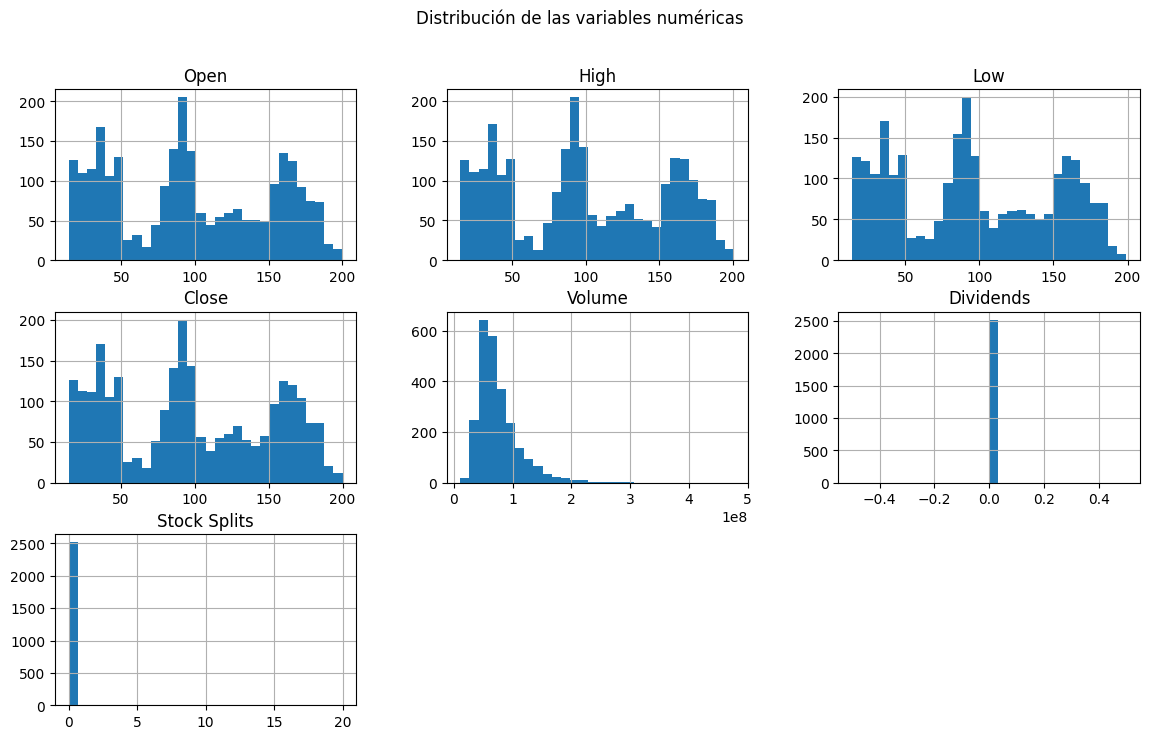

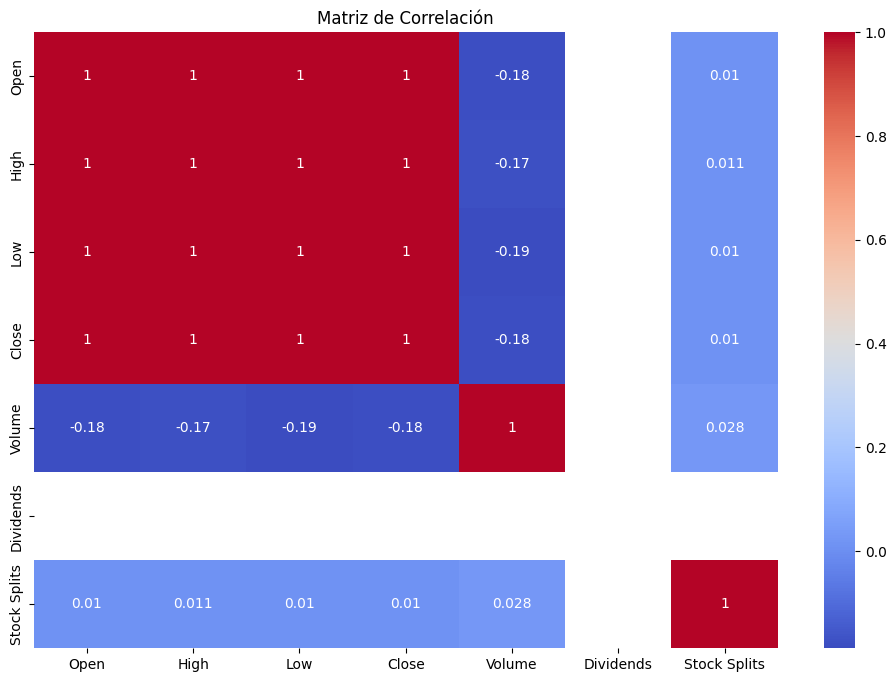

18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing


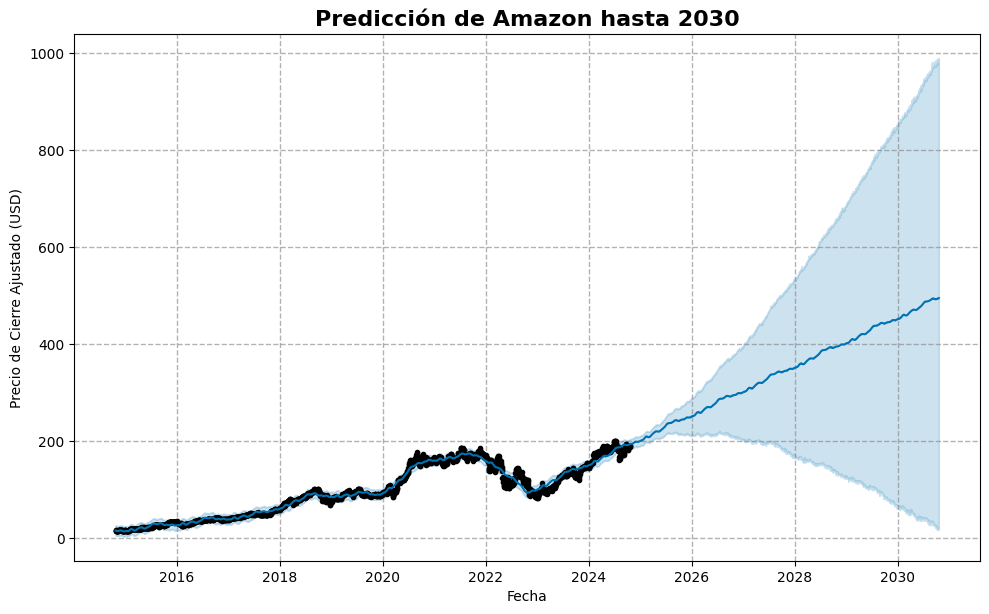

Columnas disponibles para Alphabet: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Descripción general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-10-22 00:00:00-04:00 to 2024-10-22 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Volume        2517 non-null   int64  
 5   Dividends     2517 non-null   float64
 6   Stock Splits  2517 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.3 KB
None

Descripción estadística de las variables numéricas:
              Open         High          Low        Close        Volume  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean     79.586603    80.429287  

<Figure size 1400x800 with 0 Axes>

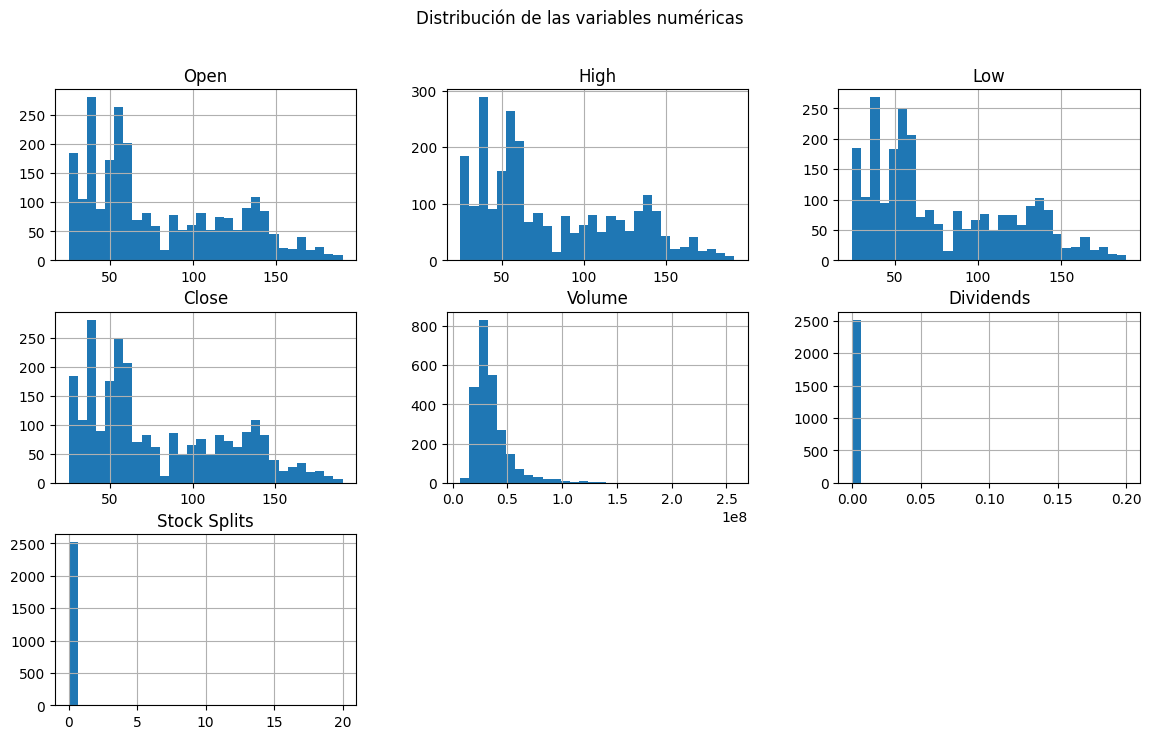

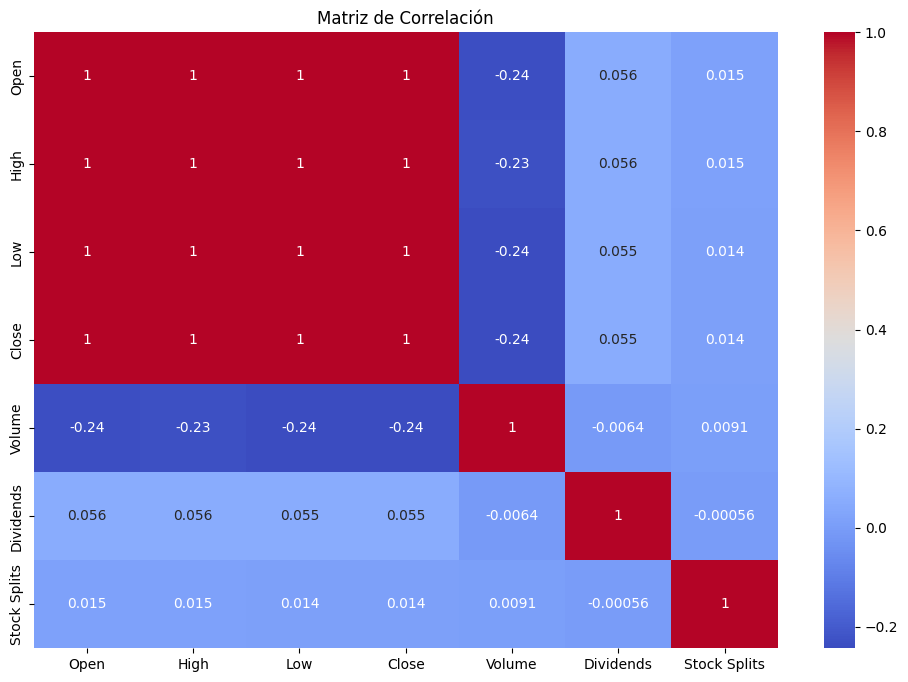

18:27:02 - cmdstanpy - INFO - Chain [1] start processing
18:27:03 - cmdstanpy - INFO - Chain [1] done processing


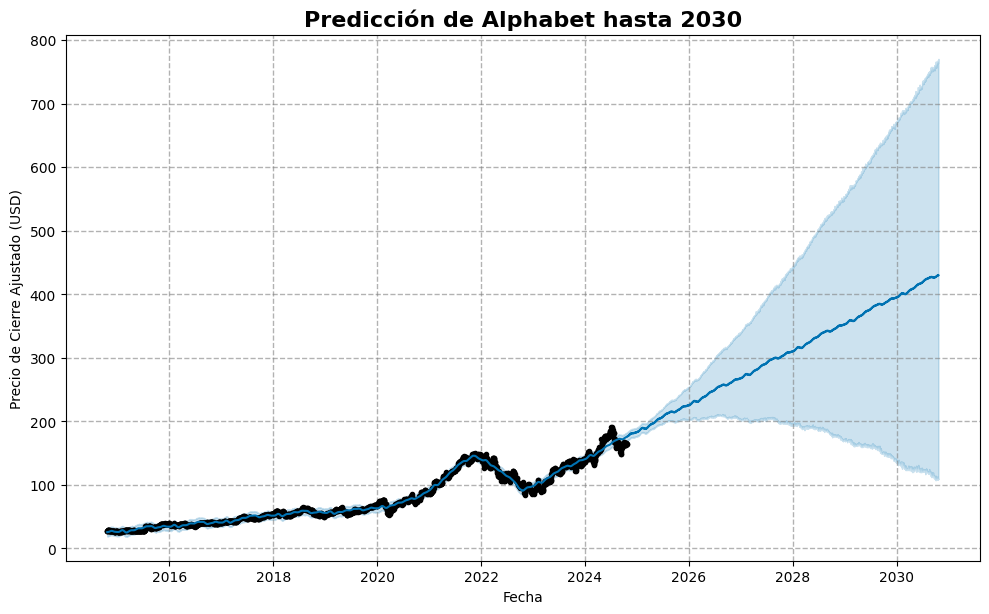

Columnas disponibles para NVIDIA: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')
Descripción general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-10-22 00:00:00-04:00 to 2024-10-22 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Volume        2517 non-null   int64  
 5   Dividends     2517 non-null   float64
 6   Stock Splits  2517 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.3 KB
None

Descripción estadística de las variables numéricas:
              Open         High          Low        Close        Volume  \
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean     18.121328    18.461064    

<Figure size 1400x800 with 0 Axes>

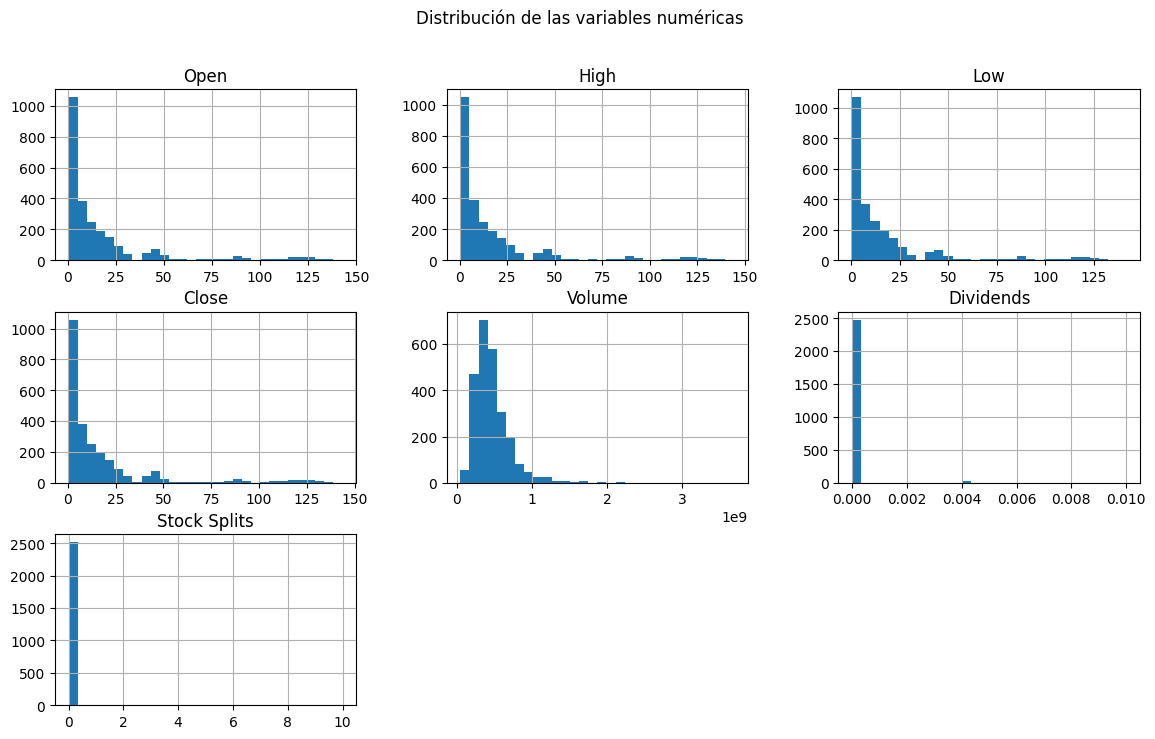

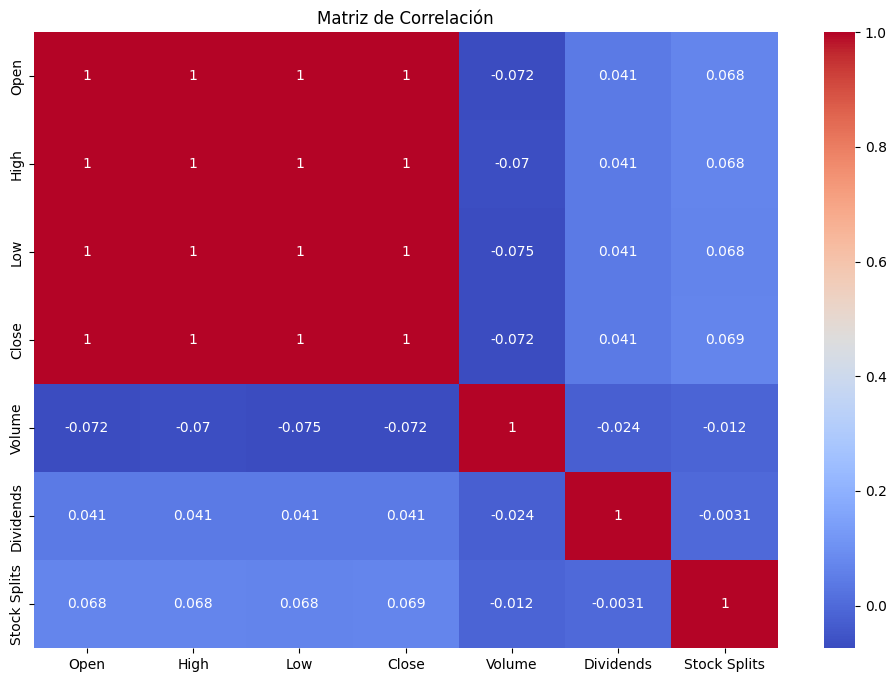

18:27:08 - cmdstanpy - INFO - Chain [1] start processing
18:27:09 - cmdstanpy - INFO - Chain [1] done processing


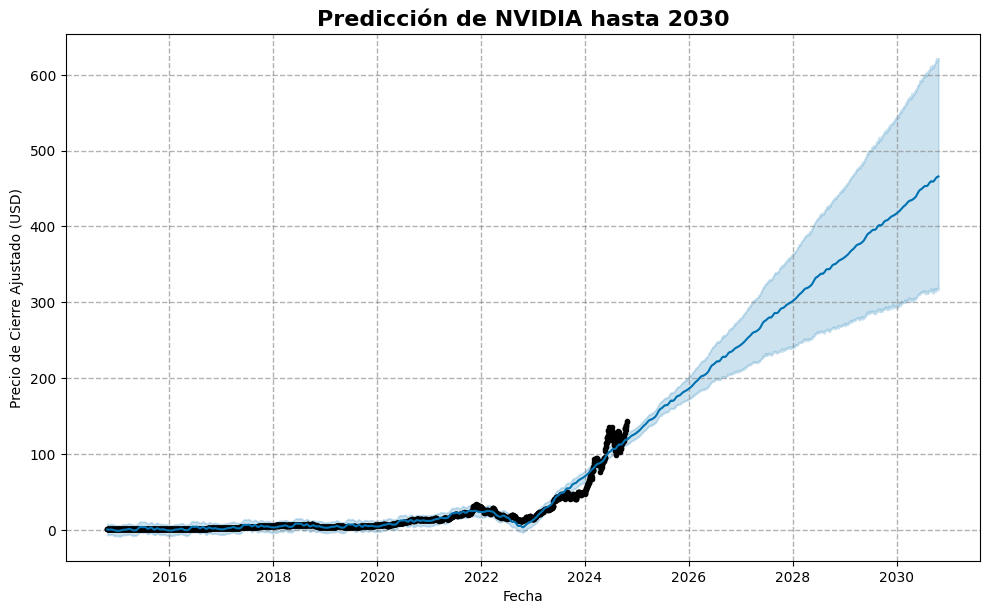

In [30]:
# Lista de compañías y sus tickers
tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Amazon': 'AMZN',
    'Alphabet': 'GOOGL',
    'NVIDIA': 'NVDA'
}

# Diccionario para almacenar predicciones
predictions = {}

# Iterar sobre cada compañía
for company, ticker in tickers.items():
    # Cargar datos (correcto, pasar el string sin las llaves)
    company_data = download_stock_data(ticker)  # Pasa ticker directamente como string
    
    # Verificar las columnas disponibles
    print(f"Columnas disponibles para {company}: {company_data.columns}")
    
    # Si 'Adj Close' no está disponible, usamos 'Close'
    if 'Adj Close' in company_data.columns:
        price_column = 'Adj Close'
    else:
        price_column = 'Close'
    
    # Realizar el EDA y limpieza
    df_cleaned = eda_and_cleaning(company_data)
    
    # Preparar los datos para Prophet: utilizar el índice como 'ds' y 'Adj Close' o 'Close' como 'y'
    df_prophet = df_cleaned.reset_index()[['Date', price_column]].rename(columns={'Date': 'ds', price_column: 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)  # Asegurarse de que no haya zona horaria
    
    # Aplicar Prophet
    model = Prophet()
    model.fit(df_prophet)
    
    # Predecir valores futuros hasta 2030
    future = model.make_future_dataframe(periods=365 * 6)
    forecast = model.predict(future)
    
    # Guardar la predicción en el diccionario
    predictions[company] = forecast

    # Graficar la predicción
    model.plot(forecast)
    plt.title(f"Predicción de {company} hasta 2030", fontsize=16, weight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre Ajustado (USD)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Guardar predicción en CSV
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(f'data/{ticker}_forecast.csv', index=False)


### Comparar predicciones

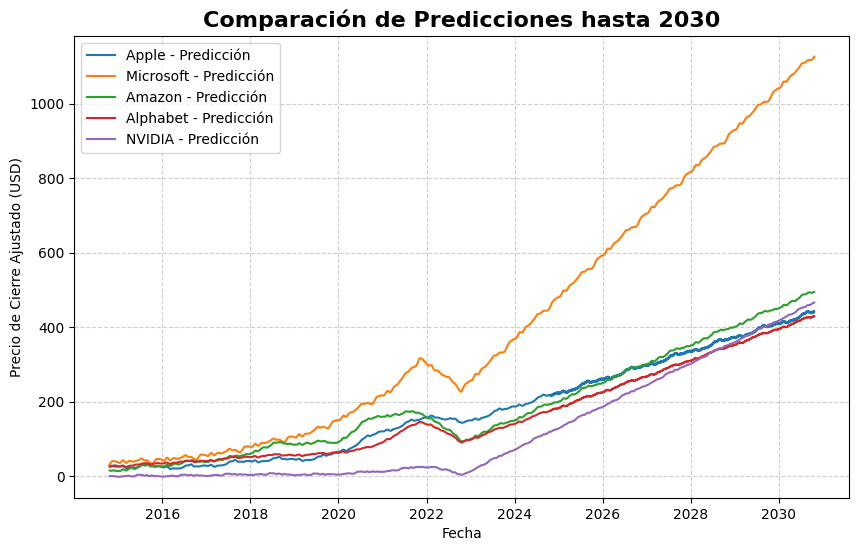

In [31]:
import matplotlib.pyplot as plt

# Gráfico de comparaciones de predicciones para todas las compañías
plt.figure(figsize=(10, 6))

for company, forecast in predictions.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=f'{company} - Predicción')

plt.title("Comparación de Predicciones hasta 2030", fontsize=16, weight='bold')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado (USD)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [48]:
import plotly.graph_objects as go
import pandas as pd

# Asegurarnos de que las fechas estén en el formato correcto de tipo datetime
for company, forecast in predictions.items():
    forecast['ds'] = pd.to_datetime(forecast['ds'])  # Asegurarse de que 'ds' es datetime

# Crear una figura
fig = go.Figure()

# Iterar sobre cada compañía y agregar los datos al gráfico
for company, forecast in predictions.items():
    # Agregar la predicción de cada compañía al gráfico
    fig.add_trace(go.Scatter(
        x=forecast['ds'], 
        y=forecast['yhat'], 
        mode='lines',
        name=f'{company} - Predicción',
        line=dict(width=2),  # Grosor de línea ajustado
        hovertemplate="<b>" + company + "</b><br>Fecha: %{x}<br>Precio Predicho: %{y:.2f} USD<extra></extra>"  # Sin f-string
    ))

# Mejorar la estética del gráfico
fig.update_layout(
    title="Comparación de Predicciones hasta 2030 para Compañías Tecnológicas",
    xaxis_title="Fecha",
    yaxis_title="Precio de Cierre Ajustado (USD)",
    legend_title="Compañía",
    template='plotly_white',  # Alternativa: plotly_dark
    width=1000, 
    height=600,
    hovermode='x unified',  # Mostrar los valores en todas las compañías en una misma fecha
    xaxis=dict(type='date')  # Asegurar que el eje x esté en formato fecha
)

# Mostrar el gráfico interactivo
fig.show()


In [52]:
import plotly.graph_objects as go
import pandas as pd

# Asegurarnos de que las fechas estén en el formato correcto de tipo datetime
for company, forecast in predictions.items():
    forecast['ds'] = pd.to_datetime(forecast['ds'])  # Asegurarse de que 'ds' es datetime

# Definir colores personalizados para cada compañía
colors = {
    'Apple': '#1f77b4',
    'Microsoft': '#ff7f0e',
    'Amazon': '#2ca02c',
    'Alphabet': '#d62728',
    'NVIDIA': '#9467bd'
}

# Crear una figura
fig = go.Figure()

# Iterar sobre cada compañía y agregar los datos al gráfico
for company, forecast in predictions.items():
    # Agregar la predicción de cada compañía al gráfico
    fig.add_trace(go.Scatter(
        x=forecast['ds'], 
        y=forecast['yhat'], 
        mode='lines',
        name=f'{company} - Predicción',
        line=dict(width=2, color=colors[company]),  # Personalización de colores y grosor
        hovertemplate="<b>" + company + "</b><br>Fecha: %{x}<br>Precio Predicho: %{y:.2f} USD<extra></extra>"
    ))
    
    # Agregar las bandas de incertidumbre (rango de confianza)
    fig.add_trace(go.Scatter(
        x=forecast['ds'],
        y=forecast['yhat_upper'],
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ))
    fig.add_trace(go.Scatter(
        x=forecast['ds'],
        y=forecast['yhat_lower'],
        fill='tonexty',  # Llena el área entre 'yhat_lower' y 'yhat_upper'
        fillcolor='rgba(68, 68, 68, 0.2)',  # Ajuste de transparencia
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ))

# Mejorar la estética del gráfico
fig.update_layout(
    title="Comparación de Predicciones hasta 2030 para Compañías Tecnológicas",
    title_font=dict(size=20, color='white'),  # Color y tamaño del título ajustado a blanco
    xaxis_title="Fecha",
    yaxis_title="Precio de Cierre Ajustado (USD)",
    legend_title="Compañía",
    template='plotly_dark',  # Tema oscuro para mejor contraste con el texto blanco
    width=1000, 
    height=600,
    hovermode='x unified',  # Mostrar los valores en todas las compañías en una misma fecha
    xaxis=dict(
        tickformat='%Y-%m-%d',  # Formato de fecha ajustado
        tickangle=-45,  # Rotación de etiquetas del eje X
        rangeslider_visible=True,  # Añade un slider en el eje X para zoom
        tickfont=dict(color='white')  # Color de las etiquetas del eje X en blanco
    ),
    yaxis=dict(
        autorange=True,
        tickfont=dict(color='white')  # Color de las etiquetas del eje Y en blanco
    ),
    font=dict(family="Arial, sans-serif", size=12, color="white"),  # Color del texto principal en blanco
    margin=dict(l=40, r=40, t=80, b=40),  # Márgenes ajustados
    paper_bgcolor='rgba(0,0,0,0)',  # Fondo transparente
    plot_bgcolor='rgba(0,0,0,0)',  # Fondo de la gráfica transparente
    legend=dict(
        title="Compañía",
        title_font=dict(color="white"),  # Color del título de la leyenda en blanco
        font=dict(color="white"),  # Color de los elementos de la leyenda en blanco
        x=0.02,
        y=0.98,
        bgcolor='rgba(0, 0, 0, 0.5)',  # Fondo semitransparente en negro para mayor contraste
        bordercolor="White",
        borderwidth=1
    )
)

# Eliminar la anotación "Evento importante" (si no es relevante)
# Si quieres eliminarla, comenta o elimina esta sección:
"""
fig.add_annotation(
    x='2023-01-01',
    y=forecast['yhat'].iloc[-1],
    text="Evento importante",  # Puedes cambiarlo por algo relevante o eliminarlo
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40,
    font=dict(color="white")  # Color de la anotación en blanco
)
"""

# Mostrar el gráfico interactivo
fig.show()
